

# Assignment - Tic-Tac-Toe

#### Parikshit Singh Tomar-parikshitsinghtomar1857@gmail.com-9910112332

#### Importing libraries

In [1]:
!pip install gym

/home/parikshit.tomar/anaconda3/lib/python3.8/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/parikshit.tomar/anaconda3/lib/python3.8/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 1.6 MB 612 kB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 662 kB/s eta 0:00:01
  Created wheel for gym: filename=gym-0.18.3-py3-none-any.whl size=1657516 sha256=1d5caafcc94178dd97b187f045073f540c6a5c2fcc21a72842ef4dedc4982805
  Stored in directory: /home/parikshit.tomar/.cache/pip/wheels/b3/03/54/9141c232861b89be935b37bdde0ea5ab472f5e18fc20623aed
Successfully built gym


In [31]:
# Importing the necessary libraries
from TCGame_Env import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [32]:
# Importing tictactoe class from environment file
env = TicTacToe()

In [33]:

# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [34]:

# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [35]:

# Defining a function which will add new Q-values to the Q-dictionary. 

def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy

In [36]:
# Defining epsilon-greedy policy here:

def epsilon_greedy(state, time):
#     epsilon = - 1/ (1 + np.exp((-time+7500000)/1700000)) + 1
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*time)
    z = np.random.random()
    if z > epsilon:
        # ===> Q value fetch max value
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)
    else:
        # ===> random action generation
        agent_actions, env_actions = env.action_space(state)
        action = random.choice(list(agent_actions))
    return action


#### Tracking the state-action pairs for checking convergence

In [37]:

# Initialising Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)

Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)
rewards_tracked =  {(2,1):0,(5,5):0, (8,3): 0, (9,7):0}

In [38]:

# Initialising states to be tracked

def initialise_tracking_states():
    sample_q_values = [('x-x-x-x-x-x-x-x-x',(6,5)),('x-x-x-x-x-x-x-x-x',(1,9)),
                       ('x-3-x-x-1-x-x-x-x',(7,5)),('x-5-x-x-x-x-5-7-x',(8,2))]
    for q_value in sample_q_values:
        state = q_value[0]
        action = q_value[1]
        state1 = Q_state(state)
        States_track[state1][action] = []  
        


initialise_tracking_states()

In [39]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [40]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [41]:
initialise_tracking_states()

#### Defining hyperparameters

In [42]:
#EPISODES = 5000000 #It takes lot of time more than 1 day even. So trying below episodes.
EPISODES = 80000

LR = 0.01   # learning rate
GAMMA = 0.91

max_epsilon = 1.0
min_epsilon = 0.001

threshold = 2000      
policy_threshold = 30000

### Q-update loop

In [43]:
start_time = time.time()

for episode in range(EPISODES):
    env = TicTacToe()
    curr_state = env.state
    isTerminated = False
    add_to_dict(curr_state)
    total_reward = 0

    while not isTerminated:
        current_state_ele = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode)
        next_state, reward, isTerminated = env.step(curr_state, curr_action)

        next_state_ele = Q_state(next_state)
        add_to_dict(next_state)

        if isTerminated:
            Q_dict[current_state_ele][curr_action] += LR * (
                (reward - Q_dict[current_state_ele][curr_action]))
        else:
            max_next = max(Q_dict[next_state_ele],
                           key=Q_dict[next_state_ele].get)
            Q_dict[current_state_ele][curr_action] += LR * (
                (reward + (GAMMA * (Q_dict[next_state_ele][max_next]))) -
                Q_dict[current_state_ele][curr_action])

        curr_state = next_state
        total_reward += reward

    # Tracking the Q-Values here
    
    if (episode == threshold-1):        #at the 1999th episode
        initialise_tracking_states()

    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')

    # Saving the Policy here
    
    if ((episode+1)% policy_threshold ) == 0:  #every 30000th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')

elapsed_time = time.time() - start_time
save_obj(States_track, 'States_tracked')
save_obj(Q_dict, 'Policy')
print(elapsed_time)                                               

116.58567976951599


#### Check the Q-dictionary

In [44]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): -0.8127744678035614,
              (0, 3): -0.7916081314829093,
              (0, 5): -0.8218900073553403,
              (0, 7): -1.83459472214486,
              (0, 9): -2.035444025007015,
              (1, 1): -0.806994545099809,
              (1, 3): -0.7698112614984264,
              (1, 5): -0.8123255547335747,
              (1, 7): -2.4653274013716553,
              (1, 9): -1.6720474922484405,
              (2, 1): -0.7973928907362697,
              (2, 3): -0.8213044471996787,
              (2, 5): -0.8115779113891347,
              (2, 7): -1.9491252891503763,
              (2, 9): -2.153927339338541,
              (3, 1): -0.8182558068224732,
              (3, 3): -0.8307255336117113,
              (3, 5): -0.7937977955165035,
              (3, 7): -1.6871216686433048,
              (3, 9): -1.9099775435228203,
              (4, 1): -0.8327489321096346,
              (4, 3): -0.8068973265563208,
              (4, 5)

In [45]:
len(Q_dict)

170775

In [46]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [47]:
# Write the code for plotting the graphs for state-action pairs tracked

### Epsilon - decay check

In [48]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,5000000)
epsilon = []
for i in range(0,5000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

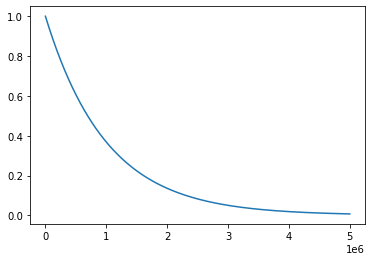

In [49]:
plt.plot(time, epsilon)
plt.show()

In [21]:

########     The END ####